<a href="https://colab.research.google.com/github/ce888-sr/CE888/blob/master/CE888_Xception_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dropout, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
import cv2
from tensorflow.keras.applications import Xception # TensorFlow ONLY
import keras, os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.layers import GlobalAveragePooling2D
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!unzip -u "/content/gdrive/My Drive/Training.zip"
!unzip -u "/content/gdrive/My Drive/Test.zip"

Archive:  /content/gdrive/My Drive/Training.zip
Archive:  /content/gdrive/My Drive/Test.zip


In [4]:
train_directory = "/content/Training/Training" #set directory to where the extracted datsets are saved
test_directory = '/content/Test/Test'

In [5]:
fire_ds = "/content/Training/Training/Fire"
noFire_ds = "/content/Training/Training/No_Fire"

In [81]:
print(len(fire_ds))
print(len(noFire_ds))

31
34


In [6]:
image_size = (254, 254)
batch_size = 32

In [83]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "/content/Training/Training", validation_split=0.2, labels = 'inferred', label_mode = 'binary', subset="training", seed=1337, image_size=image_size,
        batch_size=batch_size, shuffle=True
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "/content/Training/Training", validation_split=0.2, labels = 'inferred', label_mode = 'binary', subset="validation", seed=1337, image_size=image_size,
        batch_size=batch_size, shuffle=True
    )

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        '/content/Test/Test', labels = 'inferred', label_mode = 'binary', image_size=image_size, batch_size=batch_size
    )

Found 39375 files belonging to 2 classes.
Using 31500 files for training.
Found 39375 files belonging to 2 classes.
Using 7875 files for validation.
Found 8617 files belonging to 2 classes.


In [99]:
# 0 is Fire and 1 is NO_Fire
fire = len([name for name in os.listdir(fire_ds) if os.path.isfile(os.path.join(fire_ds, name))])
no_fire = len([name for name in os.listdir(noFire_ds) if os.path.isfile(os.path.join(noFire_ds, name))])
print({'Total # of fire': fire, 'Total # of no_fire': no_fire})


{'Total # of fire': 25018, 'Total # of no_fire': 14357}


In [96]:
#from original project https://github.com/AlirezaShamsoshoara/Fire-Detection-UAV-Aerial-Image-Classification-Segmentation-UnmannedAerialVehicle/blob/main/training.py 
#not sure if important
total = fire + no_fire
weight_for_fire = (1 / fire) * total / 2.0                                                                                             
weight_for_no_fire = (1 / no_fire) * total / 2.0

print("Weight for class fire : {:.2f}".format(weight_for_fire))
print("Weight for class No_fire : {:.2f}".format(weight_for_no_fire))

{0: 0.7869334079462788, 1: 1.371282301316431}
Weight for class fire : 0.79
Weight for class No_fire : 1.37


In [8]:
train_ds

<BatchDataset shapes: ((None, 254, 254, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [9]:
data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.1),
        ]
    )

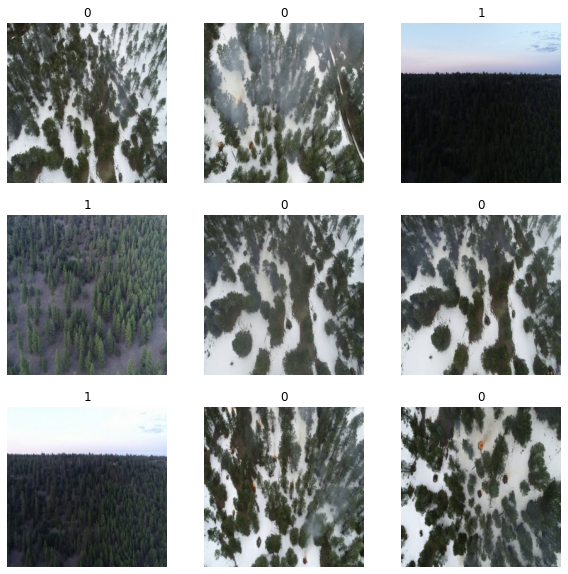

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        _ = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")



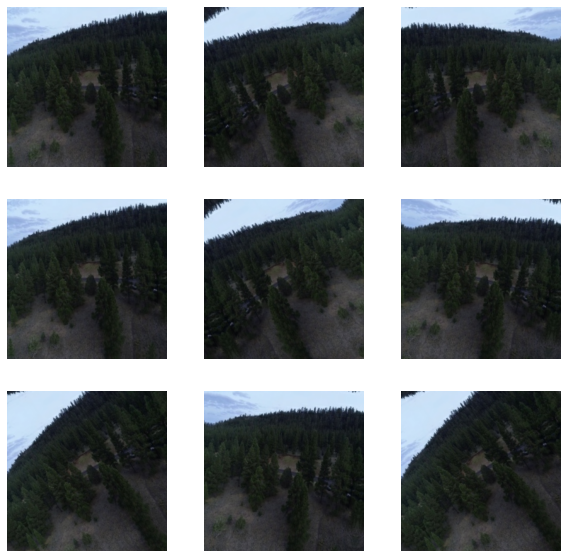

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        _ = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [12]:
#img_input = Input(shape=(224, 224, 3))

In [12]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

In [ ]:
# I was trying to correct the class inbalance by splitting the train data and then applying SMOTE but even high RAM crashes when I try to do this
#X_train =  tf.concat([x for x, y in train_ds], axis=0)
#y_train =  tf.concat([y for x, y in train_ds], axis=0)

In [56]:
#load pre trained Xception model
from keras.models import Model

base_model = Xception(input_shape=(254, 254, 3), weights='imagenet', include_top=False) #define model
base_model.trainable = False #freeze all layers in the base_model

input = keras.Input(shape=(254, 254, 3))
x = data_augmentation(input) #apply defined augmentation at random
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x) #rescale images to between 0 and 1

x = base_model(x, training=False) #make sure base_model is running in inference mode

# add additional layers
x = GlobalAveragePooling2D()(x) #convert features to vectors
x = Dropout(0.2)(x) # add dropout 0.2
output = Dense(1, activation='sigmoid')(x) #2 classes

# add layer to the pre-trained base_model
model = Model(input, output)
model.summary()

#freeze the pre-trained base_model
#for layer in base_model.layers: 
#        layer.trainable = False 

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 254, 254, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 254, 254, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 254, 254, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049

In [57]:
model.compile(optimizer='adam',
                  loss='binary_crossentropy',  # binary_crossentropy for binary classifier
                  metrics=['accuracy'])

In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks_list = [
    EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='top_model.h5', monitor ="val_loss", mode="min", save_best_only=True)]

In [16]:
len(train_ds)

985

In [59]:
epochs = 10 #set epochs to 10 while experimenting, hoever setting this higher doesn't seem to help
model.fit(train_ds,
          steps_per_epoch = len(train_ds)/epochs, #reduce steps while experimenting
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=val_ds,
          callbacks = callbacks_list)

Epoch 1/10
98/98 [==============================] - 37s 348ms/step - loss: 0.3753 - accuracy: 0.8416 - val_loss: 0.1333 - val_accuracy: 0.9609
Epoch 2/10
98/98 [==============================] - 33s 338ms/step - loss: 0.1361 - accuracy: 0.9596 - val_loss: 0.0985 - val_accuracy: 0.9751
Epoch 3/10
98/98 [==============================] - 33s 338ms/step - loss: 0.1150 - accuracy: 0.9676 - val_loss: 0.0861 - val_accuracy: 0.9780
Epoch 4/10
98/98 [==============================] - 33s 338ms/step - loss: 0.0974 - accuracy: 0.9658 - val_loss: 0.0813 - val_accuracy: 0.9759
Epoch 5/10
98/98 [==============================] - 33s 338ms/step - loss: 0.0922 - accuracy: 0.9679 - val_loss: 0.0732 - val_accuracy: 0.9780
Epoch 6/10
98/98 [==============================] - 33s 338ms/step - loss: 0.0837 - accuracy: 0.9706 - val_loss: 0.0685 - val_accuracy: 0.9787
Epoch 7/10
98/98 [==============================] - 33s 338ms/step - loss: 0.0706 - accuracy: 0.9777 - val_loss: 0.0699 - val_accuracy: 0.9784

In [30]:
#model.load_weights(filepath='top_model.h5')

In [60]:
#train last 2 blocks of xception model
for layer in model.layers[:116]:
        layer.trainable = False
for layer in model.layers[116:]:
        layer.trainable = True

In [61]:
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [62]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='top_model.h5', monitor ="val_loss", mode="min", save_best_only=True)]

In [63]:
epochs = 10
model.fit(train_ds,
          steps_per_epoch = len(train_ds)/epochs,
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=val_ds,
          callbacks = my_callbacks)

Epoch 1/10
98/98 [==============================] - 36s 344ms/step - loss: 0.0613 - accuracy: 0.9767 - val_loss: 0.0592 - val_accuracy: 0.9811
Epoch 2/10
98/98 [==============================] - 33s 337ms/step - loss: 0.0571 - accuracy: 0.9845 - val_loss: 0.0592 - val_accuracy: 0.9811
Epoch 3/10
98/98 [==============================] - 33s 337ms/step - loss: 0.0560 - accuracy: 0.9826 - val_loss: 0.0592 - val_accuracy: 0.9811
Epoch 4/10
98/98 [==============================] - 33s 337ms/step - loss: 0.0621 - accuracy: 0.9780 - val_loss: 0.0592 - val_accuracy: 0.9811
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


In [36]:
#model.load_weights(filepath='final_model.h5')

In [64]:
from sklearn.metrics import accuracy_score

y_true = tf.concat([y for x, y in test_ds], axis=0)

## Test Accuracy
predictions = model.predict(test_ds)


In [75]:
#y_pred = [1 if i>=0.5 else 0 for i in predictions] #round 
y_pred = predictions.round()
test_acc = accuracy_score(y_true, y_pred)
print(test_acc)

0.5392828130439828


In [76]:
#Fire (class 0) and No_fire (class 1)
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{0.0: 5795, 1.0: 2822}

In [77]:
#results_eval = model.evaluate(test_ds, batch_size=batch_size)

270/270 [==============================] - 26s 95ms/step - loss: 0.6449 - accuracy: 0.6936


In [78]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[3481 1656]
 [2314 1166]]
              precision    recall  f1-score   support

         0.0       0.60      0.68      0.64      5137
         1.0       0.41      0.34      0.37      3480

    accuracy                           0.54      8617
   macro avg       0.51      0.51      0.50      8617
weighted avg       0.52      0.54      0.53      8617

